# Face Recognition Project

In [ ]:
!nvidia-smi

Mon Nov 13 18:40:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Import dataset

**Download the PINS Face dataset**

In [ ]:
# pins_face
!gdown 1o2TkrzwObdbmlAOHdD-h8AegGi4jcYTw

Downloading...
From: https://drive.google.com/uc?id=1o2TkrzwObdbmlAOHdD-h8AegGi4jcYTw
To: /content/pins_face.zip
100% 390M/390M [00:09<00:00, 42.3MB/s]


**Download the 10 identities of PINS FACE dataset (step 3.2)**

In [1]:
!gdown 148cqpnIwhfMm7sLESU6487Wbn4hBYi-T

Downloading...
From: https://drive.google.com/uc?id=148cqpnIwhfMm7sLESU6487Wbn4hBYi-T
To: /content/Pins_Face_subset_10.zip
100% 46.6M/46.6M [00:00<00:00, 69.0MB/s]


**Download the 5 Celebs dataset**

In [ ]:
!gdown 1YI5ElVwG3tSY5QdqnL3z-X8RN9QVtWZM

Downloading...
From: https://drive.google.com/uc?id=1YI5ElVwG3tSY5QdqnL3z-X8RN9QVtWZM
To: /content/archive.zip
100% 5.28M/5.28M [00:00<00:00, 34.8MB/s]


**Extract the whole PINS face dataset**

In [ ]:
import zipfile
import os
with zipfile.ZipFile('pins_face.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

**Extract the 5 Celebs dataset**

In [ ]:
import zipfile
import os
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

**Extract 10 celebrities from Pins Faces (Step 3.2)**

In [2]:
import zipfile
import os
with zipfile.ZipFile('Pins_Face_subset_10.zip', 'r') as zip_ref_01:
    zip_ref_01.extractall(os.getcwd())

## 2. Preparing training and validation set

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers, models, applications
import tensorflow as tf
import pandas as pd


**Define training and validation directory for 5 CELEBS (Step 3.1)**

In [ ]:
train_dir = os.path.join(os.getcwd(), 'train')
val_dir = os.path.join(os.getcwd(), 'val')

**Define train directory for 10 celebrities from PINS FACES (Step 3.2)**

In [4]:
train_dir = os.path.join(os.getcwd(), 'Pins_Face_subset_10')

***Define train directory for  PINS FACES ***

In [ ]:
train_dir = os.path.join(os.getcwd(), '105_classes_pins_dataset')

Batch size and target shape

In [5]:
batch_size = 64
target_shape = (160, 160)

Train directory for 5 celebs (step 3.1)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0,
  seed=123,
  image_size=target_shape,
  batch_size=batch_size)

Found 1671 files belonging to 10 classes.


Validation directory for 5 celebs (step 3.1)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  validation_split=0,
  seed=123,
  image_size=target_shape,
  batch_size=batch_size)

**Training and Validation directories for the subset 10 PINS FACES (Step 3.2) and respectively PINS FACES**

In [6]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  seed=3710,
  subset="both",
  image_size=target_shape,
  batch_size=batch_size)

Found 1671 files belonging to 10 classes.
Using 1337 files for training.
Using 334 files for validation.


In [7]:
class_names = train_ds.class_names

In [8]:
val_ds.class_names

['pins_Adriana Lima',
 'pins_Chris Hemsworth',
 'pins_Dwayne Johnson',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Morgan Freeman',
 'pins_Rihanna',
 'pins_Shakira Isabel Mebarak',
 'pins_Zoe Saldana',
 'pins_scarlett johansson']

In [9]:
train_ds.class_names

['pins_Adriana Lima',
 'pins_Chris Hemsworth',
 'pins_Dwayne Johnson',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Morgan Freeman',
 'pins_Rihanna',
 'pins_Shakira Isabel Mebarak',
 'pins_Zoe Saldana',
 'pins_scarlett johansson']

## 3. Building model with Inception Resnet V2 as base model

### Data augmentation

In [10]:
class RandomColorDistortion(tf.keras.layers.Layer):
  def __init__(self, contrast_range=[0.75, 1.25],
               brightness_delta=[-0.1, 0.1], **kwargs):
    super(RandomColorDistortion, self).__init__(**kwargs)
    self.contrast_range = contrast_range
    self.brightness_delta = brightness_delta

  def call(self, images, training=False):
    if not training:
      return images
    contrast = np.random.uniform(
    self.contrast_range[0], self.contrast_range[1])
    brightness = np.random.uniform(
    self.brightness_delta[0], self.brightness_delta[1])



    images = tf.image.adjust_contrast(images, contrast)
    images = tf.image.adjust_brightness(images, brightness)
    images = tf.clip_by_value(images, 0, 255)
    return images

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  RandomColorDistortion(name='random_contrast_brightness/none'),
])

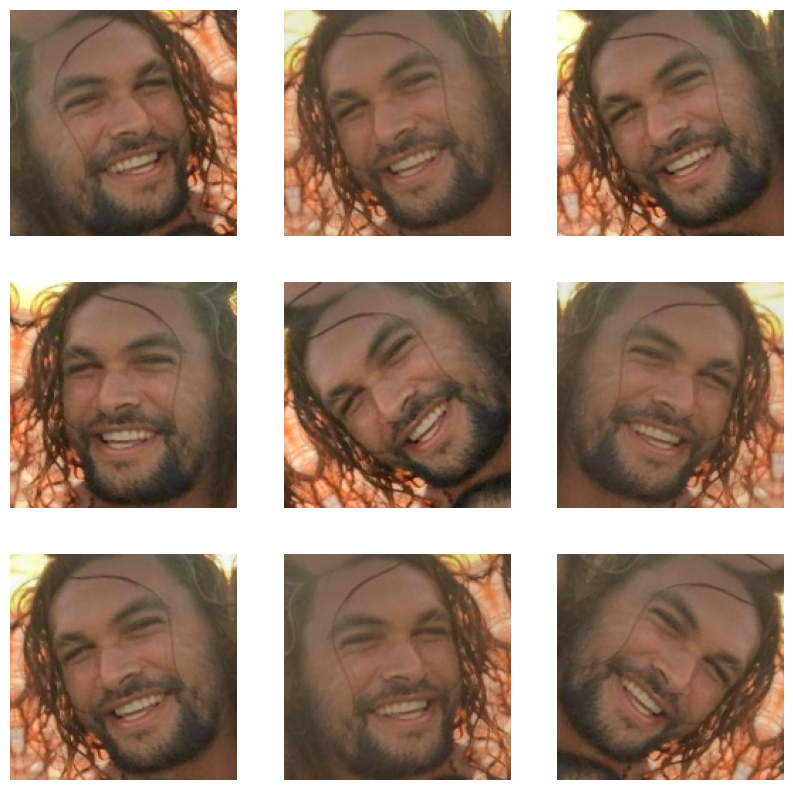

In [12]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Preprocessing inputs

In [13]:
preprocess_input = applications.inception_resnet_v2.preprocess_input
tf.keras.layers.Rescaling(1/255) # [0, 1]

### Base model : Inception Resnet V2


In [14]:
base_model = applications.inception_resnet_v2.InceptionResNetV2(weights="imagenet",
                             input_shape=target_shape + (3,),
                             include_top=False)

# remember to choose only one of the two following methods.(comment out the other)

219055592/219055592 [==============================] - 5s 0us/step


### Fine Tuning

In [15]:
# the following commented lines are fine tuning
trainable = False
number_of_layer=0
for layer in base_model.layers:
    number_of_layer+=1
    if layer.name == "conv2d_202":
        trainable = True
    layer.trainable = trainable

In [ ]:
# this is He initialization of the weights
init = tf.keras.initializers.HeUniform(seed=123) # GlorotUniform() is also a good choice, feel free to explore
for w in base_model.trainable_variables:
    w.assign(init(w.shape))

In [16]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 79, 79, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 79, 79, 32)           0         ['batch_norm

### Model output

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


### Assembly of layers

In [18]:

inputs = tf.keras.Input(shape=target_shape + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(len(train_ds.class_names),
                       activation=tf.keras.activations.softmax)(x)
model = tf.keras.Model(inputs, outputs)





## Model description

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, 3, 3, 1536)        54336736  
 ional)                                                          
                                                             

### Choosing optimizers

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Creating callbacks to stop training when target goal is reached

In [21]:
class CustomCallback(tf.keras.callbacks.Callback):



    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        acc = logs['accuracy']
        if val_acc >= 0.8 and np.abs(val_acc-acc)<0.03:
            self.model.stop_training = True
            print("goal reached\n")
        print('\n')
        print("End epoch {} of training\n".format(epoch))
        print('-------------------------------------------')

### Model Training

In [22]:
epochs=30
customCallback = CustomCallback()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[customCallback]
)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5124 - accuracy: 0.4630

End epoch 0 of training

-------------------------------------------
21/21 [==============================] - 39s 514ms/step - loss: 1.5124 - accuracy: 0.4630 - val_loss: 1.5893 - val_accuracy: 0.5269
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9021 - accuracy: 0.6657

End epoch 1 of training

-------------------------------------------
21/21 [==============================] - 5s 239ms/step - loss: 0.9021 - accuracy: 0.6657 - val_loss: 1.3286 - val_accuracy: 0.5629
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.7722 - accuracy: 0.7292

End epoch 2 of training

-------------------------------------------
21/21 [==============================] - 5s 212ms/step - loss: 0.7722 - accuracy: 0.7292 - val_loss: 1.0001 - val_accuracy: 0.6527
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.7816

End epoch 3 of trai

In [23]:
pd.DataFrame(history.history).to_csv('inception_resnet_v2_007_06-12-23.csv')

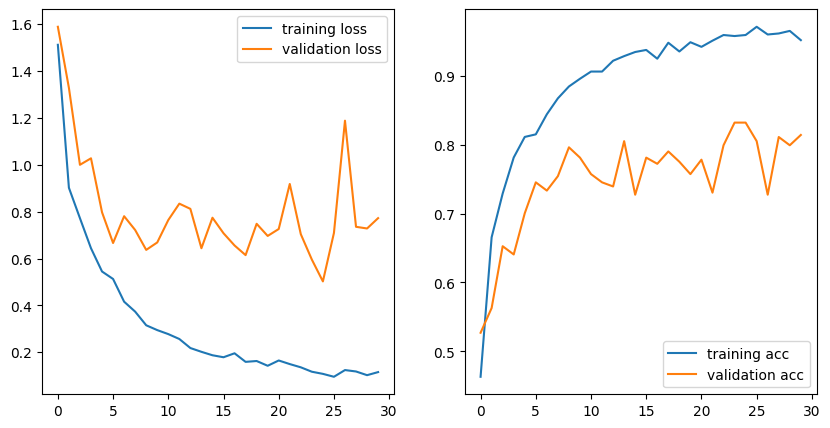

In [24]:
import matplotlib.pyplot as plt


training_loss, training_acc = history.history['loss'], history.history['accuracy']
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(training_loss, label='training loss')
ax[0].plot(val_loss, label='validation loss')
ax[0].legend()

ax[1].plot(training_acc, label='training acc')
ax[1].plot(val_acc, label='validation acc')
ax[1].legend()

### Download the weights from former good test with Resnet50

In [ ]:
!gdown 1n9lLe_fuRSEbnphhmPbNvX80xe1xWuQg

Downloading...
From: https://drive.google.com/uc?id=1n9lLe_fuRSEbnphhmPbNvX80xe1xWuQg
To: /content/weights_resnet50.tar
100% 157M/157M [00:01<00:00, 148MB/s]


In [ ]:
!tar -xf weights_resnet50.tar

In [ ]:
model.load_weights('./checkpoints/val_acc_0.92')

### Model Performance on training

In [25]:
model.evaluate(train_ds)

21/21 [==============================] - 4s 160ms/step - loss: 0.1096 - accuracy: 0.9641


[0.10961159318685532, 0.9640987515449524]

### Model Performance in Validation

In [26]:
model.evaluate(val_ds)

6/6 [==============================] - 1s 143ms/step - loss: 0.7725 - accuracy: 0.8144


[0.7725116610527039, 0.8143712282180786]

### After training, you can save your weights here

In [27]:
model.save_weights('./checkpoints/inception_resnet_v2_007') # create a new folder, and use file name as you wish

In [29]:
!tar -czvf weights_007.tar checkpoints/

checkpoints/
checkpoints/checkpoint
checkpoints/inception_resnet_v2_007.data-00000-of-00001
checkpoints/inception_resnet_v2_007.index


### For the next cells, upload your own images to play with. Have fun.

In [ ]:
img = tf.keras.utils.load_img(
    'Morgan_Freeman_Portrait_003.jpg', target_size=target_shape
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
#img_array = preprocess_input(img_array)
img_array.shape

TensorShape([1, 160, 160, 3])

This image most likely belongs to pins_Morgan Freeman with a 72.10 percent confidence.


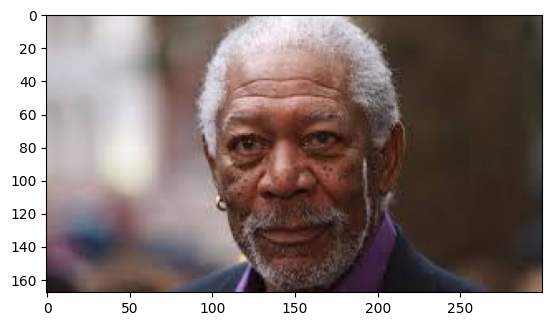

In [ ]:
import PIL

plt.imshow(PIL.Image.open('Morgan_Freeman_Portrait_003.jpg'));

predictions = model(img_array, training=False)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)


In [ ]:
tf.reduce_sum(predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [ ]:
model.predict(img_array)

1/1 [==============================] - 0s 27ms/step


array([[5.5206794e-08, 3.8543494e-06, 5.5127090e-04, 1.4748008e-03,
        9.9797004e-01]], dtype=float32)